#### Convolution CNN for leaning images and processing - using high-level Keras preprocessing utilities and layers to read a directory of images on disk.

https://www.tensorflow.org/tutorials/load_data/images

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
#import tensorflow_datasets as tfds

In [3]:
print(tf.__version__)

2.5.0


#### Dataset
candlesticks/<br />
    buy<br />
    sell<br />

##### Define path for dataset

In [4]:
import pathlib
data_dir = pathlib.Path('candlesticks')

##### Validate total candlestick counts

In [5]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

52


##### Read a sample buy image

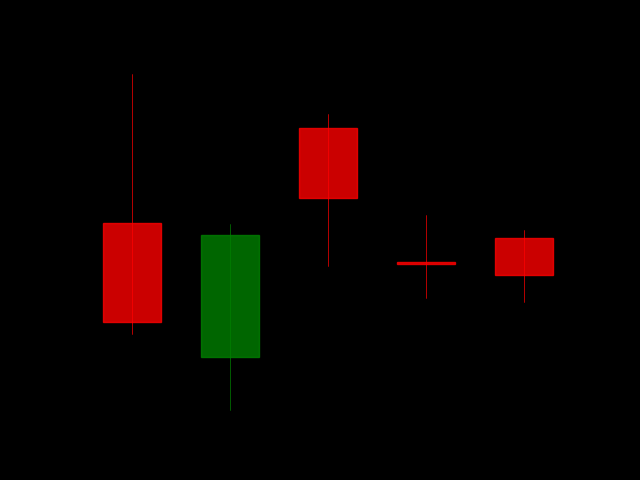

In [6]:
candlesticks = list(data_dir.glob('buy/*.png'))
PIL.Image.open(str(candlesticks[0]))
#PIL.Image.open(str(candlesticks[0])).size

### Load using tf.keras.preprocessing.ipynb_checkpoints/

#### Create a dataset

##### Define some parameters for the loader:

In [7]:
#batch_size = 1
img_height = 255
img_width = 255

##### It's good practice to use a validation split when developing your model. Will use 80% of the images for training and 20% for validation.

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width)
#  batch_size=batch_size
)

Found 53 files belonging to 2 classes.
Using 43 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width)
  #batch_size=batch_size
)

Found 53 files belonging to 2 classes.
Using 10 files for validation.


##### You can find the class names in the class_names attribute on these datasets.

In [10]:
class_names = train_ds.class_names
print(class_names)

['buy', 'sell']


### Visualize the data

##### Here are the first 9 images from the training dataset.


Bad key savefig.frameon in file C:\Users\chakravartiraghavan\anaconda3\envs\deepenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file C:\Users\chakravartiraghavan\anaconda3\envs\deepenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file C:\Users\chakravartiraghavan\anaconda3\envs\deepenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename

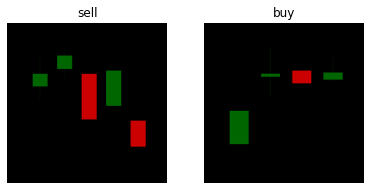

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(2):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

##### we wil train a model using these datasets by passing them to model.fit. You can also manually iterate over the dataset and retrieve batches of images:

In [12]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 255, 255, 3)
(32,)


##### The image_batch is a tensor of the shape (1, 180, 180, 3). This is a batch of 1 images of shape 180x180x3 (the last dimension referes to color channels RGB). The label_batch is a tensor of the shape (1,), these are the corresponding labels to the 32 images.

### Standardize the data

##### The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the [0, 1] range by using the tf.keras.layers.experimental.preprocessing.Rescaling layer.

In [13]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

##### There are two ways to use this layer. You can apply it to the dataset by calling map:

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.87404835


##### Or, you can include the layer inside your model definition to simplify deployment. We will use the second approach here.

### Configure the dataset for performance

Let's make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

.cache() keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

.prefetch() overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the data performance guide.

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Train a model

For completeness, you will show how to train a simple model using the datasets you have just prepared. This model has not been tuned in any way - the goal is to show you the mechanics using the datasets you just created. To learn more about image classification, visit this tutorial.

In [63]:
num_classes = 2

model = tf.keras.Sequential([
#  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [83]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=False)

training_set = train_datagen.flow_from_directory(
            data_dir,
            target_size=(128, 128),
            batch_size=32,
            class_mode='categorical')

validation_set = train_datagen.flow_from_directory(
            data_dir,
            target_size=(128, 128),
            batch_size=32,
            class_mode='categorical')

Found 53 images belonging to 2 classes.
Found 53 images belonging to 2 classes.


```python 
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(
            '/content/drive/My Drive/Colab Notebooks/dataset',
            target_size=(128, 128),
            batch_size=30,
            class_mode='categorical')

# test_set = test_datagen.flow_from_directory(
#             '../dataset/test_set/',
#             target_size=(64, 64),
#             batch_size=32,
#             class_mode='binary')

classifier.fit_generator(
            training_set,
            steps_per_epoch=40,
            epochs=10,
            validation_data=training_set,
            validation_steps=80)
```

In [84]:
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy', #tf.losses.categorical_crossentropy(from_logits=True),
  metrics=['accuracy'])

In [85]:
import matplotlib.pyplot as plt

In [86]:
len(training_set[0][0])

32

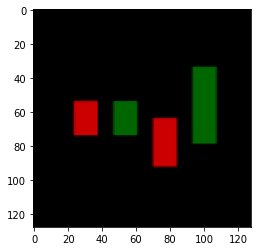

In [87]:
plt.imshow(training_set.next()[0][0])

In [90]:
model.fit(
            training_set, 
            steps_per_epoch=1,
            epochs=20,
#            validation_split=.1
#            validation_data=validation_set
#            validation_data=training_set,
#            validation_steps=80
)

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.2589 - accuracy: 0.9375
Epoch 2/20
1/1 [==============================] - 1s 722ms/step - loss: 0.1279 - accuracy: 0.9688
Epoch 3/20
1/1 [==============================] - 1s 929ms/step - loss: 0.1854 - accuracy: 0.9062
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 0.1527 - accuracy: 0.9375
Epoch 5/20
1/1 [==============================] - 1s 899ms/step - loss: 0.1301 - accuracy: 0.9524
Epoch 6/20
1/1 [==============================] - 0s 485ms/step - loss: 0.0856 - accuracy: 1.0000
Epoch 7/20
1/1 [==============================] - 1s 682ms/step - loss: 0.0997 - accuracy: 0.9688
Epoch 8/20
1/1 [==============================] - 1s 918ms/step - loss: 0.0338 - accuracy: 1.0000
Epoch 9/20
1/1 [==============================] - 1s 820ms/step - loss: 0.0747 - accuracy: 0.9688
Epoch 10/20
1/1 [==============================] - 1s 599ms/step - loss: 0.0159 - accuracy: 1.0000
Epoch 11/20
1/1 [========

In [24]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
#  verbose='2'
)

Epoch 1/10
2/2 [==============================] - 7s 1s/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 5.6635 - val_accuracy: 0.6000
Epoch 2/10
2/2 [==============================] - 8s 2s/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 6.5766 - val_accuracy: 0.6000
Epoch 3/10
2/2 [==============================] - 4s 1s/step - loss: 5.9096e-04 - accuracy: 1.0000 - val_loss: 7.4365 - val_accuracy: 0.6000
Epoch 4/10
2/2 [==============================] - 4s 885ms/step - loss: 2.1023e-04 - accuracy: 1.0000 - val_loss: 8.2343 - val_accuracy: 0.6000
Epoch 5/10
2/2 [==============================] - 3s 965ms/step - loss: 8.2910e-05 - accuracy: 1.0000 - val_loss: 8.9625 - val_accuracy: 0.6000
Epoch 6/10
2/2 [==============================] - 4s 963ms/step - loss: 3.8105e-05 - accuracy: 1.0000 - val_loss: 9.6195 - val_accuracy: 0.6000
Epoch 7/10
2/2 [==============================] - 20s 1s/step - loss: 2.0060e-05 - accuracy: 1.0000 - val_loss: 10.2037 - val_accuracy: 0.6000
Epoch 8/10

In [19]:
#model.evaluate(X_test, y_test, verbose=0)

In [20]:
model.evaluate(train_ds)

2/2 [==============================] - 3s 269ms/step - loss: 0.0053 - accuracy: 1.0000


[0.005253512412309647, 1.0]

In [23]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset